# Assignment 3-> Decision trees with a toy task and the UCI Adult dataset

In [2]:
import collections
from io import StringIO

import numpy as np
import pandas as pd
import pydotplus  # pip install pydotplus
import seaborn as sns
import numpy as np
from ipywidgets import Image
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import Image
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (10, 8)


# Part 1. Toy dataset “Will They? Won’t They?"

Your goal is to figure out how decision trees work by walking through a toy problem. While a single decision tree does not yield outstanding results, other performant algorithms like gradient boosting and random forests are based on the same idea. That is why knowing how decision trees work might be useful.

We’ll go through a toy example of binary classification - Person A is deciding whether they will go on a second date with Person B. It will depend on their looks, eloquence, alcohol consumption (only for example), and how much money was spent on the first date.

Creating the Dataset

In [3]:
# Creating the Dataset with Dummy Variables

def create_df(dic , feature_list):
    out = pd.DataFrame(dic)
    out = pd.concat([out , pd.get_dummies(out[feature_list])], axis = 1)
    out.drop(feature_list , axis=1 , inplace = True)
    return out

# Some feature values are present in train and absent in test and vice-versa.
def intersect_features(train , test):
    common_feat = list(set(train.keys()) & set(test.keys()))
    return train[common_feat] , test[common_feat]


In [4]:
features = ["Looks", "Alcoholic_beverage", "Eloquence", "Money_spent"]

Generating the Training Data

In [5]:
df_train = {}
df_train["Looks"] = [
    "handsome",
    "handsome",
    "handsome",
    "repulsive",
    "repulsive",
    "repulsive",
    "handsome",
]

df_train["Alcoholic_beverage"] = ["yes", "yes", "no", "no", "yes", "yes", "yes"]
df_train["Eloquence"] = ["high", "low", "average", "average", "low", "high", "average"]
df_train["Money_spent"] = ["lots", "little", "lots", "little", "lots", "lots", "lots"]
df_train["Will_go"] = LabelEncoder().fit_transform(["+", "-", "+", "-", "-", "+", "+"])


df_train = create_df(df_train , features)

df_train


,Will_go,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Eloquence_low,Money_spent_little,Money_spent_lots
0,0,True,False,False,True,False,True,False,False,True
1,1,True,False,False,True,False,False,True,True,False
2,0,True,False,True,False,True,False,False,False,True
3,1,False,True,True,False,True,False,False,True,False
4,1,False,True,False,True,False,False,True,False,True
5,0,False,True,False,True,False,True,False,False,True
6,0,True,False,False,True,True,False,False,False,True


Making the Test Data


In [6]:
df_test = {}
df_test["Looks"] = ["handsome", "handsome", "repulsive"]
df_test["Alcoholic_beverage"] = ["no", "yes", "yes"]
df_test["Eloquence"] = ["average", "high", "average"]
df_test["Money_spent"] = ["lots", "little", "lots"]
df_test = create_df(df_test, features)
df_test

,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Money_spent_little,Money_spent_lots
0,True,False,True,False,True,False,False,True
1,True,False,False,True,False,True,True,False
2,False,True,False,True,True,False,False,True


Some of the features present in the Test Set are not present in the Train set , therefore we adjust that using the function we made.

In [7]:
y = df_train["Will_go"]
df_train, df_test = intersect_features(train=df_train, test=df_test)
df_train

,Eloquence_high,Money_spent_little,Alcoholic_beverage_yes,Looks_handsome,Looks_repulsive,Eloquence_average,Alcoholic_beverage_no,Money_spent_lots
0,True,False,True,True,False,False,False,True
1,False,True,True,True,False,False,False,False
2,False,False,False,True,False,True,True,True
3,False,True,False,False,True,True,True,False
4,False,False,True,False,True,False,False,True
5,True,False,True,False,True,False,False,True
6,False,False,True,True,False,True,False,True


In [8]:
df_test

,Eloquence_high,Money_spent_little,Alcoholic_beverage_yes,Looks_handsome,Looks_repulsive,Eloquence_average,Alcoholic_beverage_no,Money_spent_lots
0,False,False,False,True,False,True,True,True
1,True,True,True,True,False,False,False,False
2,False,False,True,False,True,True,False,True


Question 1 Train a decision tree using sklearn on the training data. You may choose any depth for the tree.

In [9]:
tree = DecisionTreeClassifier(criterion= "gini" , max_depth = 3 , random_state=17)

tree.fit(df_train , y)

,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,17
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [10]:
def visualise_tree(tree , features):
    dot_data = export_graphviz(tree , feature_names = features)
    graph = pydotplus.graph_from_dot_data(dot_data)
    return Image(graph.create_png())

Display the resulting tree using graphviz.

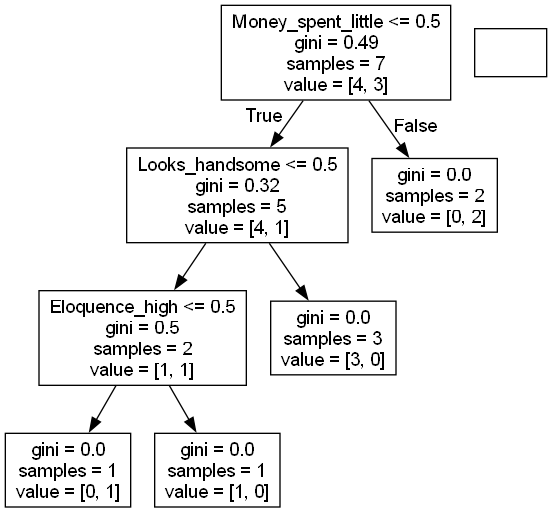

In [11]:
visualise_tree(tree , df_train.columns)

# Part 2 Functions for calculating entropy and information gain.
Consider the following warm-up example: we have 9 blue balls and 11 yellow balls. Let ball have label 1 if it is blue, 0 otherwise.

In [12]:
balls = [1 for i in range(9)] + [0 for i in range(11)]

Next split the balls into two groups:

In [13]:
# Two Groups
balls_left = [1 for i in range(8)] + [0 for i in range(5)]  # 8 blue and 5 yellow
balls_right = [1 for i in range(1)] + [0 for i in range(6)]  # 1 blue and 6 yellow

# Implement a function to calculate the Shannon Entropy

Shanon Entropy is given by $$\Large S = -\sum_{i=1}^{N}p_i \log_2{p_i},$$ where $p_i$ is the probability of finding the system in the ith state. 

In [14]:
def entropy(a_list):
    states = set(a_list)
    Total_Entropy = 0
    for i in states:
        p_i = len([x for x in a_list if x == i])/len(a_list)
        Total_Entropy -= p_i * np.log2(p_i)
    return Total_Entropy


In [15]:
print(entropy(balls))  # 9 blue и 11 yellow
print(entropy(balls_left))  # 8 blue и 5 yellow
print(entropy(balls_right))  # 1 blue и 6 yellow
print(entropy([1, 2, 3, 4, 5, 6]))  # entropy of a fair 6-sided die

0.9927744539878083
0.9612366047228759
0.5916727785823275
2.584962500721156


3. What is the entropy of the state given by the list balls_left?

0.9612366047228759

4. What is the entropy of a fair dice? (where we look at a dice as a system with 6 equally probable states)?

2.584962500721156


Implement an Information Gain calculator where IG is given by: $$\Large IG(Q) = S_O - \sum_{i=1}^{q}\frac{N_i}{N}S_i,$$ , where $q$ is the number of groups after the split, $N_i$ is number of objects from the sample in which variable $Q$ is equal to the $i$-th value.

In [16]:
# information gain calculation
def information_gain(root, left, right):
    """ root - initial data, left and right - two partitions of initial data"""
    s_0 = entropy(root)
    subtraction = 0
    for i in [left , right]:
        subtraction += (len(i)/len(root)) * entropy(i)
    Info_Gain = s_0 - subtraction
    return Info_Gain

    

In [17]:
information_gain(balls,balls_left,balls_right)

np.float64(0.16088518841412436)

# Part 3 UCI Adult Dataset

UCI Adult (no need to download it, we have a copy in the course repository): classify people using demographic data - whether they earn more than $50,000 per year or not.

Feature descriptions:

Age – continuous feature

Workclass – continuous feature

fnlwgt – final weight of object, continuous feature

Education – categorical feature

Education_Num – number of years of education, continuous feature

Martial_Status – categorical feature

Occupation – categorical feature

Relationship – categorical feature

Race – categorical feature

Sex – categorical feature

Capital_Gain – continuous feature

Capital_Loss – continuous feature

Hours_per_week – continuous feature

Country – categorical feature

Target – earnings level, categorical (binary) feature.

In [18]:
# Importing Dataset

DATA_URL = "https://raw.githubusercontent.com/Yorko/mlcourse.ai/main/data/"

In [19]:
data_train = pd.read_csv(DATA_URL + "adult_train.csv" , sep = ";") # The separating Delimiter is a semi-colon
data_train.head()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [20]:
data_test = pd.read_csv(DATA_URL + "adult_test.csv" , sep = ";")
data_test.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
16277,39,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K.
16278,64,NaN,321403.0,HS-grad,9.0,Widowed,NaN,Other-relative,Black,Male,0.0,0.0,40.0,United-States,<=50K.
16279,38,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
16280,44,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K.
16281,35,Self-emp-inc,182148.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,60.0,United-States,>50K.


In [21]:
data_test=data_test.loc[1:].reset_index(drop = True)


In [22]:
#Binary encoding Target
data_train.loc[data_train["Target"] == " <=50K", "Target"] = 0
data_train.loc[data_train["Target"] == " >50K", "Target"] = 1

data_test.loc[data_test["Target"] == " <=50K.", "Target"] = 0
data_test.loc[data_test["Target"] == " >50K.", "Target"] = 1


#Primary Data Analysis

In [23]:
data_train.describe(include="all")

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
count,32561.000000,30725,3.256100e+04,32561,32561.000000,32561,30718,32561,32561,32561,32561.000000,32561.000000,32561.000000,31978,32561.0
unique,NaN,8,NaN,16,NaN,7,14,6,5,2,NaN,NaN,NaN,41,2.0
top,NaN,Private,NaN,HS-grad,NaN,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,United-States,0.0
freq,NaN,22696,NaN,10501,NaN,14976,4140,13193,27816,21790,NaN,NaN,NaN,29170,24720.0
mean,38.581647,NaN,1.897784e+05,NaN,10.080679,NaN,NaN,NaN,NaN,NaN,1077.648844,87.303830,40.437456,NaN,NaN
std,13.640433,NaN,1.055500e+05,NaN,2.572720,NaN,NaN,NaN,NaN,NaN,7385.292085,402.960219,12.347429,NaN,NaN
min,17.000000,NaN,1.228500e+04,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
25%,28.000000,NaN,1.178270e+05,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,37.000000,NaN,1.783560e+05,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
75%,48.000000,NaN,2.370510e+05,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN,NaN


In [24]:
data_train["Target"].value_counts(normalize=True)

Target
0    0.75919
1    0.24081
Name: proportion, dtype: float64

We shall plot the distributions of all the variables


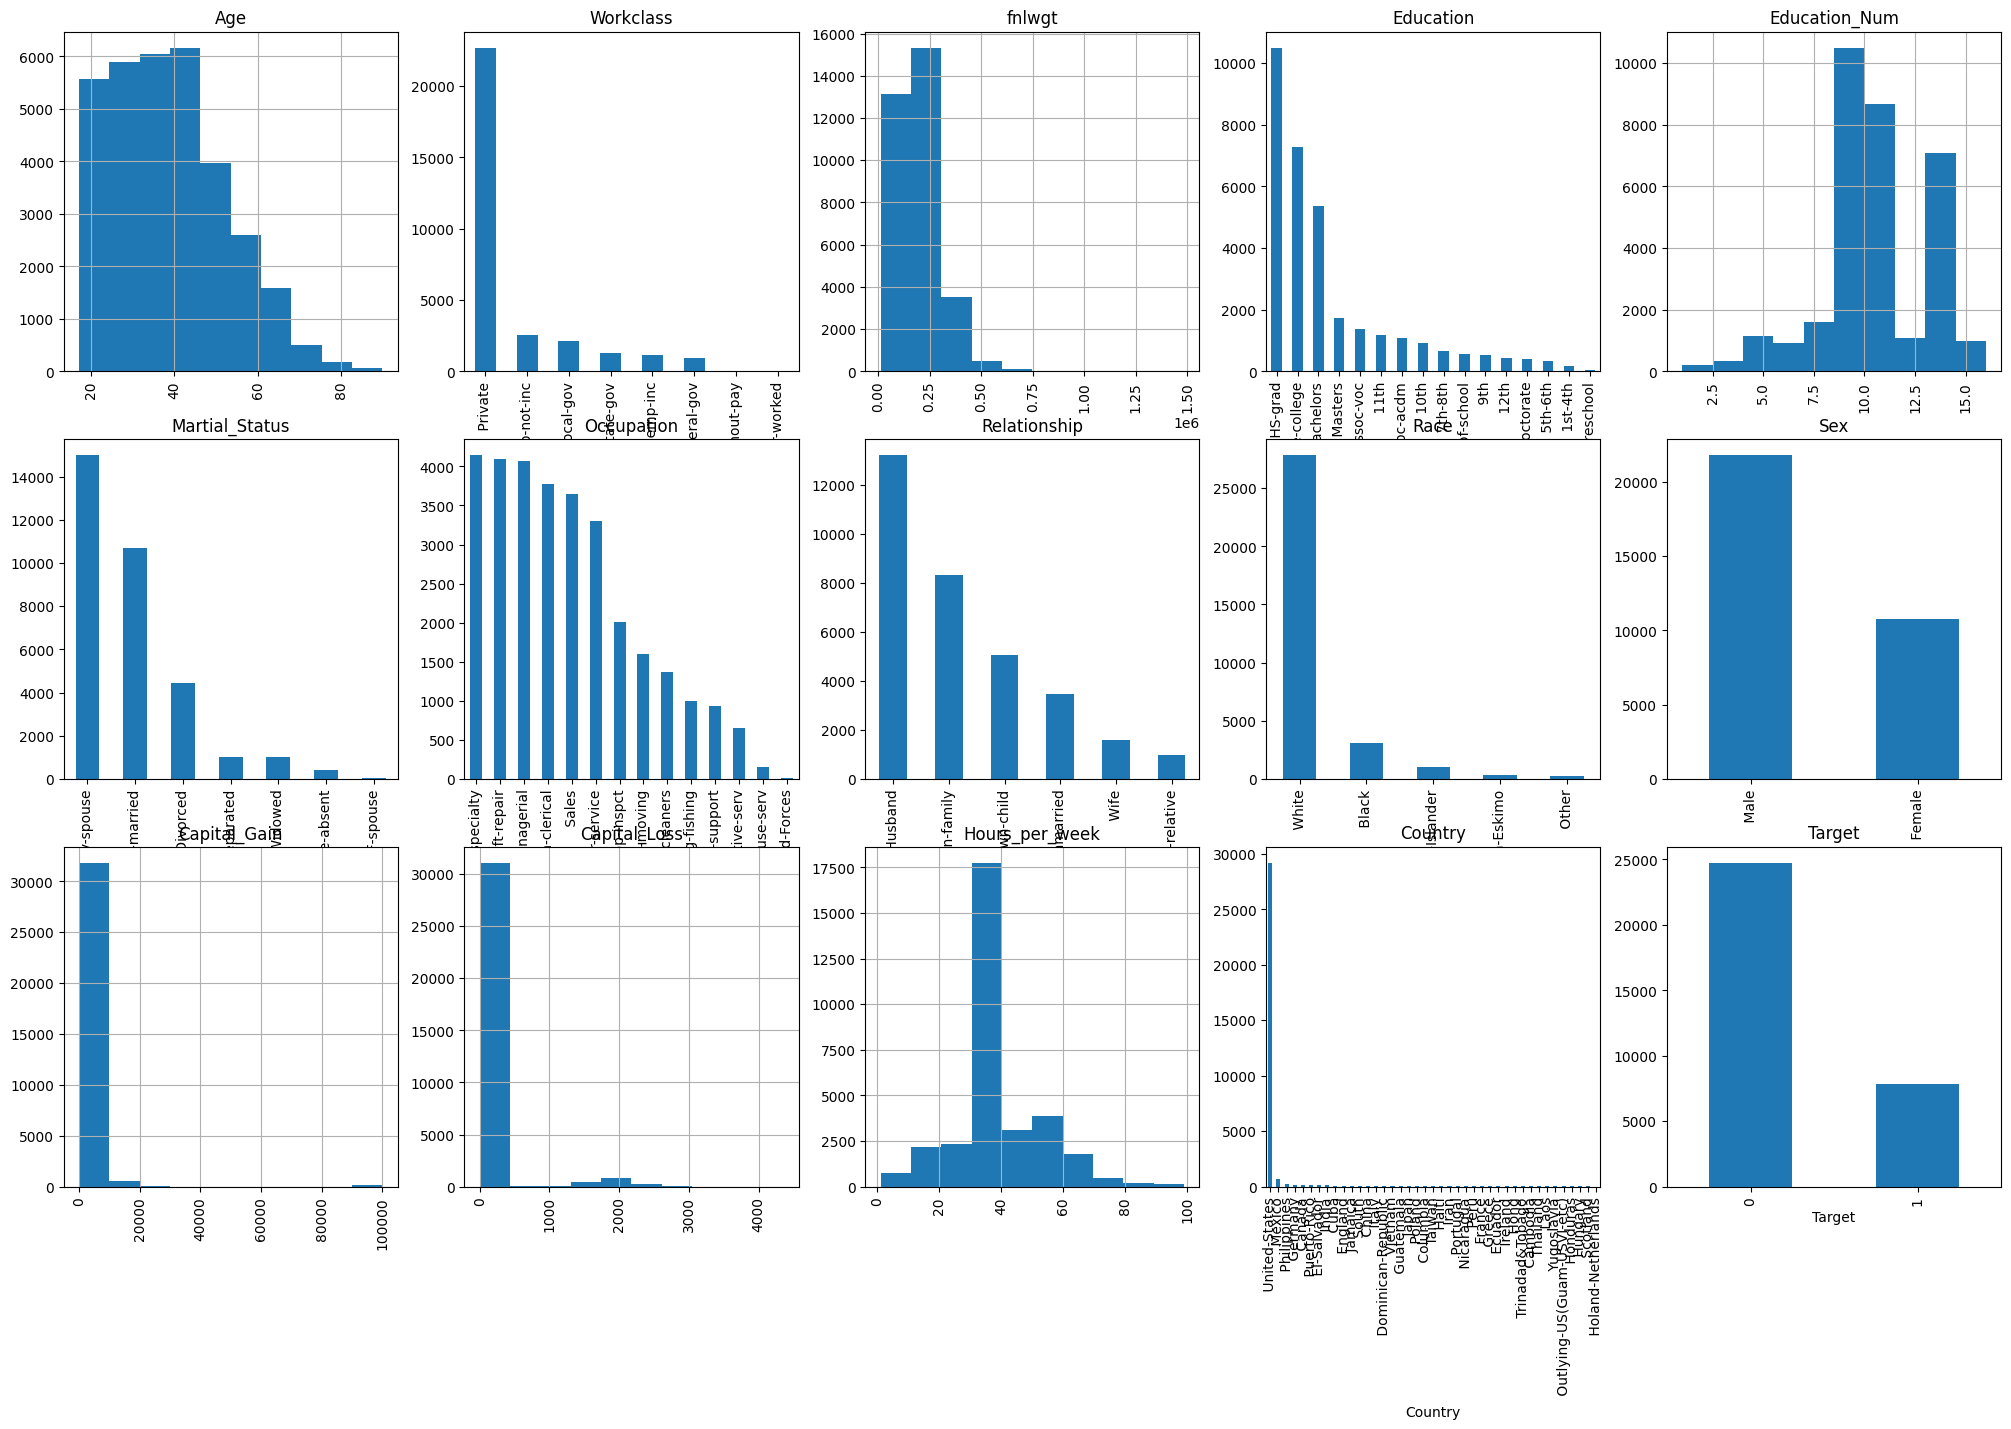

In [25]:
fig = plt.figure(figsize=(25,15))
cols = 5
rows = int(data_train.shape[1]/cols)
for i , column in enumerate(data_train.columns):
    ax = fig.add_subplot(rows , cols , i +1)
    ax.set_title(column)
    if data_train.dtypes[column] == "object":
        data_train[column].value_counts().plot(kind="bar", axes=ax)
    else:
        data_train[column].hist(axes=ax)
        plt.xticks(rotation="vertical")

plt.show();

In [26]:
#Checking Data Types

data_train.dtypes

Age                int64
Workclass         object
fnlwgt             int64
Education         object
Education_Num      int64
Martial_Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_Gain       int64
Capital_Loss       int64
Hours_per_week     int64
Country           object
Target            object
dtype: object

In [27]:
data_train.dtypes

Age                int64
Workclass         object
fnlwgt             int64
Education         object
Education_Num      int64
Martial_Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_Gain       int64
Capital_Loss       int64
Hours_per_week     int64
Country           object
Target            object
dtype: object

Age in the test dataset is treated as an object , therefore we change this

In [28]:
data_test["Age"] = data_test["Age"].astype("int")

Also we’ll cast all float features to int type to keep types consistent between our train and test data.

In [29]:
data_test["fnlwgt"] = data_test["fnlwgt"].astype(int)
data_test["Education_Num"] = data_test["Education_Num"].astype(int)
data_test["Capital_Gain"] = data_test["Capital_Gain"].astype(int)
data_test["Capital_Loss"] = data_test["Capital_Loss"].astype(int)
data_test["Hours_per_week"] = data_test["Hours_per_week"].astype(int)

We also save the targets seperately

In [30]:
y_train = data_train.pop("Target")
y_test = data_test.pop("Target")


Fill in missing data for continuous features with their median values, for categorical features with their mode.

In [31]:
# choose categorical and continuous features from data

categorical_columns = [
    c for c in data_train.columns if data_train[c].dtype.name=="object"
                       ]

numerical_columns = [
    c for c in data_train.columns if data_train[c].dtype.name != "object"
]

print("categorical_columns:", categorical_columns)
print("numerical_columns:", numerical_columns)

categorical_columns: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country']
numerical_columns: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week']


Checking for Missing Values

In [32]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education_Num   32561 non-null  int64 
 5   Martial_Status  32561 non-null  object
 6   Occupation      30718 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital_Gain    32561 non-null  int64 
 11  Capital_Loss    32561 non-null  int64 
 12  Hours_per_week  32561 non-null  int64 
 13  Country         31978 non-null  object
dtypes: int64(6), object(8)
memory usage: 3.5+ MB


In [33]:
#filling in missing data

for c in categorical_columns:
    data_train[c].fillna(data_train[c].mode()[0], inplace=True )
    data_test[c].fillna(data_train[c].mode()[0], inplace=True)

for c in numerical_columns:
    data_train[c].fillna(data_train[c].median(), inplace=True)
    data_test[c].fillna(data_train[c].median(), inplace=True)



C:\Users\kvssr\AppData\Local\Temp\ipykernel_25792\1614604650.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_train[c].fillna(data_train[c].mode()[0], inplace=True )
C:\Users\kvssr\AppData\Local\Temp\ipykernel_25792\1614604650.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a co

In [34]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education_Num   32561 non-null  int64 
 5   Martial_Status  32561 non-null  object
 6   Occupation      32561 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital_Gain    32561 non-null  int64 
 11  Capital_Loss    32561 non-null  int64 
 12  Hours_per_week  32561 non-null  int64 
 13  Country         32561 non-null  object
dtypes: int64(6), object(8)
memory usage: 3.5+ MB


We’ll dummy code some categorical features: Workclass, Education, Martial_Status, Occupation, Relationship, Race, Sex, Country. It can be done via pandas method get_dummies

In [35]:
data_train = pd.concat(
    [data_train[numerical_columns] ,pd.get_dummies(data_train[categorical_columns])] , axis =1 
)


data_test = pd.concat(
    [data_test[numerical_columns], pd.get_dummies(data_test[categorical_columns])],
    axis=1,
)

In [36]:
set(data_train.columns) - set(data_test.columns)

{'Country_ Holand-Netherlands'}

We can see that the test dataframe does not contain any mention of the Netherlands . Therefore we create a new 0 values column

In [37]:
data_test["Country_ Holand-Netherlands"] = 0

In [38]:
X_train = data_train
X_test = data_test

# 3.1 Decision tree without parameter tuning

Train a decision tree (DecisionTreeClassifier) with a maximum depth of 3, and evaluate the accuracy metric on the test data. Use parameter random_state = 17 for results reproducibility

In [39]:
y_train = pd.Series(y_train).astype(int)
y_test = pd.Series(y_test).astype(int)

In [40]:
tree = DecisionTreeClassifier(criterion= "gini" , max_depth = 3 , random_state=17)

tree.fit(X_train , y_train)


,criterion,'gini'
,splitter,'best'
,max_depth,3
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,17
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


Testing Accuracy

In [44]:
tree_predictions = tree.predict(X_test[X_train.columns])

accuracy_score(tree_predictions , y_test)

0.8447884036607088

# 3.2 Decision tree with parameter tuning
Train a decision tree (DecisionTreeClassifier, random_state = 17). Find the optimal maximum depth using 5-fold cross-validation (GridSearchCV).

In [45]:
tree_params  = {
    "max_depth" : range(2,17)
    }

locally_best_tree = GridSearchCV(tree , tree_params , n_jobs = -1 , verbose = True , cv = 5)

locally_best_tree.fit(X_train , y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


,estimator,DecisionTreeC...ndom_state=17)
,param_grid,"{'max_depth': range(2, 17)}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,True
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [50]:
local_tree_predictions =locally_best_tree.predict(X_test[X_train.columns])

accuracy_score(local_tree_predictions , y_test)

0.8579939807137154

In [53]:
X_test[X_train.columns].shape , X_test.shape

((16281, 105), (16281, 105))

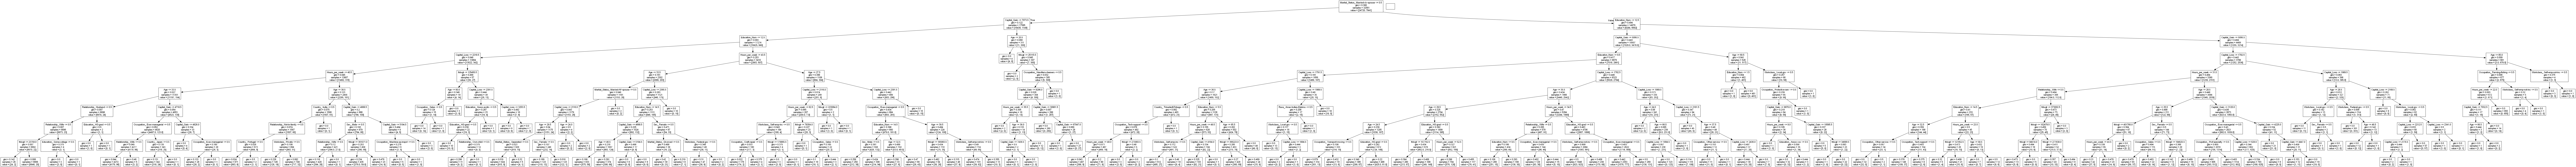

In [55]:
visualise_tree(locally_best_tree.best_estimator_ , X_train.columns)